In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.data import DataLoader
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from graph_transformer import GT
from utils import pre_process, pre_process_with_summary, basic_pre_process_with_summary, get_n_params, get_optimizer
import datetime
from tqdm import tqdm
from tensorboardX import SummaryWriter
import pytz

In [2]:
parser = argparse.ArgumentParser(description='PyTorch implementation of relative positional encodings and relation-aware self-attention for graph Transformers')
args = parser.parse_args("")

args.dataset = 'ogbg-molhiv'
args.n_classes = 1
args.lr = 3e-4
args.n_hid = 512
args.n_heads = 8
args.n_layer = 4
args.dropout = 0.3
args.num_epochs = 50
args.k_hop_neighbors = 3
args.k_hop = True
args.weight_decay = 1e-2
args.bsz      = 512
# args.bsz      = 448
args.strategies = ['ea', 'rw_inf_sum']
args.summary_node = True
args.hier_levels = 3
args.lap_k = None
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.metric = 'rocauc'
print("device:", args.device)

device: cuda


In [3]:
print("Loading data...")
print("dataset: {} ".format(args.dataset))
tz = pytz.timezone('US/Pacific')
time_now = datetime.datetime.now(tz).strftime('%m-%d_%H:%M:%S')

if args.summary_node:
    pre_transform = lambda d : rw_concat_pre_process_with_summary(d, args)
    root_path= f'dataset/{args.dataset}/rw_concat_with_summary_{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/with_summary_k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')

else:
    pre_transform = lambda d : pre_process(d, args)
    root_path= f'dataset/{args.dataset}/{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')
    
    
dataset = PygGraphPropPredDataset(name=args.dataset, pre_transform=pre_transform, root = root_path)
evaluator = Evaluator(name=args.dataset)
split_idx = dataset.get_idx_split()
edge_dim_dict = {'ea': None, \
                 'disc': {
#                      'sd': (dataset.data.sd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'cn': (dataset.data.cn_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'hsd': (dataset.data.hsd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                    },
                 'cont': {
                     **{('rw_' + str(k)): args.n_hid for k in range(1, args.k_hop_neighbors + 1)}
                 }
                }
model = GT(args.n_hid, args.n_classes, args.n_heads, args.n_layer, edge_dim_dict, args.dropout, args.summary_node, args.lap_k).to(args.device)

Loading data...
dataset: ogbg-molhiv 


In [4]:
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

In [5]:
print('Model #Params: %d' % get_n_params(model))

criterion = torch.nn.BCEWithLogitsLoss(reduction = "mean")

optimizer = get_optimizer(model, weight_decay = args.weight_decay, learning_rate = args.lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 500, eta_min=1e-6)
scheduler.step(-500)

Model #Params: 10338817


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

In [6]:
import seaborn as sb
def mat_visualize(node_size, edge_index, edge_attr):
    mat = np.zeros((node_size, node_size))
    for e, v in zip(edge_index, edge_attr):
        mat[e[0]][e[1]] = v
    sb.heatmap(mat)

/opt/conda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def turn_prob(inp):
    prob = torch.sigmoid(inp)
    prob = torch.cat([prob, 1-prob], dim=1)
    return prob

In [8]:
train_mask = torch.zeros(len(dataset), dtype=bool)
valid_mask = torch.zeros(len(dataset), dtype=bool)
test_mask = torch.zeros(len(dataset), dtype=bool)

train_mask[split_idx["train"]] = True
valid_mask[split_idx["valid"]] = True
test_mask[split_idx["test"]] = True
def entropy_loss(pred, label):
    return torch.mean(torch.sum(-label * pred, dim=1))

In [9]:
stats = []
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    train_adv  = []
    y_true = []
    y_scores = []
    all_idx = torch.randperm(len(dataset))
    for batch_idx in tqdm(range(len(all_idx) // args.bsz)):
        batch = all_idx[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        train_msk = train_mask[batch]    
        data = Batch.from_data_list(dataset[batch])
        data.to(args.device)
        
        strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
        out = model(data.x, data.batch, data.edge_index, strats)
        with torch.no_grad():
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            adv_out = model(data.x, data.batch, data.edge_index, strats)
        
        loss = criterion(out[train_msk], data.y[train_msk].float())
        adv_loss = entropy_loss(turn_prob(out).log(), turn_prob(adv_out))
        (loss + 0.5 * adv_loss).backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        train_loss += [loss.item()]
        train_adv  += [adv_loss.item()]
        
        y_true += [data.y]
        y_scores += [out]

    input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
    train_metric = evaluator.eval(input_dict)[args.metric]
    

    model.eval()
    with torch.no_grad():
        valid_loss = []
        y_true = []
        y_scores = []
        for num_iters, data in enumerate(tqdm(valid_loader)):
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            valid_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        valid_metric = evaluator.eval(input_dict)[args.metric]
        
        test_loss = []
        y_true = []
        y_scores = []
        for data in test_loader:
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            test_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        test_metric = evaluator.eval(input_dict)[args.metric]

    print('Epoch %d: LR: %.5f, Train loss: %.3f Train %s: %.3f Train Adv: %.3f Valid loss: %.3f  Valid %s: %.3f \
        Test loss: %.3f  Test %s: %.3f' \
          % (epoch + 1, optimizer.param_groups[0]['lr'], np.average(train_loss), args.metric, train_metric, \
             np.average(train_adv), np.average(valid_loss), args.metric, valid_metric, \
             np.average(test_loss), args.metric, test_metric))
    stats += [[epoch, np.average(train_loss), train_metric, np.average(valid_loss), valid_metric, np.average(test_loss), test_metric]]

  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1: LR: 0.00002, Train loss: 0.259 Train rocauc: 0.508 Train Adv: 0.346 Valid loss: 0.093  Valid rocauc: 0.542         Test loss: 0.158  Test rocauc: 0.586


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2: LR: 0.00009, Train loss: 0.162 Train rocauc: 0.502 Train Adv: 0.162 Valid loss: 0.089  Valid rocauc: 0.634         Test loss: 0.145  Test rocauc: 0.648


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3: LR: 0.00017, Train loss: 0.161 Train rocauc: 0.524 Train Adv: 0.159 Valid loss: 0.090  Valid rocauc: 0.643         Test loss: 0.138  Test rocauc: 0.668


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4: LR: 0.00025, Train loss: 0.157 Train rocauc: 0.615 Train Adv: 0.159 Valid loss: 0.087  Valid rocauc: 0.669         Test loss: 0.131  Test rocauc: 0.687


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5: LR: 0.00029, Train loss: 0.152 Train rocauc: 0.662 Train Adv: 0.150 Valid loss: 0.089  Valid rocauc: 0.735         Test loss: 0.129  Test rocauc: 0.706


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6: LR: 0.00029, Train loss: 0.145 Train rocauc: 0.708 Train Adv: 0.148 Valid loss: 0.083  Valid rocauc: 0.778         Test loss: 0.128  Test rocauc: 0.741


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7: LR: 0.00025, Train loss: 0.142 Train rocauc: 0.728 Train Adv: 0.146 Valid loss: 0.079  Valid rocauc: 0.782         Test loss: 0.126  Test rocauc: 0.733


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8: LR: 0.00017, Train loss: 0.137 Train rocauc: 0.747 Train Adv: 0.142 Valid loss: 0.078  Valid rocauc: 0.799         Test loss: 0.121  Test rocauc: 0.752


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9: LR: 0.00009, Train loss: 0.131 Train rocauc: 0.763 Train Adv: 0.138 Valid loss: 0.078  Valid rocauc: 0.790         Test loss: 0.121  Test rocauc: 0.749


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10: LR: 0.00002, Train loss: 0.130 Train rocauc: 0.770 Train Adv: 0.136 Valid loss: 0.080  Valid rocauc: 0.787         Test loss: 0.122  Test rocauc: 0.752


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 11: LR: 0.00000, Train loss: 0.126 Train rocauc: 0.791 Train Adv: 0.132 Valid loss: 0.078  Valid rocauc: 0.791         Test loss: 0.121  Test rocauc: 0.753


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 12: LR: 0.00003, Train loss: 0.127 Train rocauc: 0.779 Train Adv: 0.135 Valid loss: 0.084  Valid rocauc: 0.793         Test loss: 0.127  Test rocauc: 0.754


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 13: LR: 0.00009, Train loss: 0.126 Train rocauc: 0.782 Train Adv: 0.132 Valid loss: 0.081  Valid rocauc: 0.782         Test loss: 0.122  Test rocauc: 0.756


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 14: LR: 0.00017, Train loss: 0.128 Train rocauc: 0.773 Train Adv: 0.134 Valid loss: 0.081  Valid rocauc: 0.780         Test loss: 0.124  Test rocauc: 0.757


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 15: LR: 0.00025, Train loss: 0.129 Train rocauc: 0.771 Train Adv: 0.136 Valid loss: 0.076  Valid rocauc: 0.769         Test loss: 0.115  Test rocauc: 0.766


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 16: LR: 0.00029, Train loss: 0.129 Train rocauc: 0.770 Train Adv: 0.137 Valid loss: 0.073  Valid rocauc: 0.767         Test loss: 0.121  Test rocauc: 0.750


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 17: LR: 0.00029, Train loss: 0.129 Train rocauc: 0.775 Train Adv: 0.136 Valid loss: 0.081  Valid rocauc: 0.771         Test loss: 0.122  Test rocauc: 0.758


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 18: LR: 0.00025, Train loss: 0.126 Train rocauc: 0.773 Train Adv: 0.131 Valid loss: 0.076  Valid rocauc: 0.771         Test loss: 0.119  Test rocauc: 0.754


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 19: LR: 0.00017, Train loss: 0.124 Train rocauc: 0.783 Train Adv: 0.132 Valid loss: 0.074  Valid rocauc: 0.790         Test loss: 0.117  Test rocauc: 0.753


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 20: LR: 0.00009, Train loss: 0.121 Train rocauc: 0.790 Train Adv: 0.130 Valid loss: 0.072  Valid rocauc: 0.786         Test loss: 0.115  Test rocauc: 0.778


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 21: LR: 0.00002, Train loss: 0.117 Train rocauc: 0.813 Train Adv: 0.127 Valid loss: 0.076  Valid rocauc: 0.778         Test loss: 0.116  Test rocauc: 0.781


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 22: LR: 0.00000, Train loss: 0.115 Train rocauc: 0.813 Train Adv: 0.122 Valid loss: 0.074  Valid rocauc: 0.779         Test loss: 0.115  Test rocauc: 0.781


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 23: LR: 0.00003, Train loss: 0.114 Train rocauc: 0.812 Train Adv: 0.122 Valid loss: 0.076  Valid rocauc: 0.781         Test loss: 0.116  Test rocauc: 0.782


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 24: LR: 0.00009, Train loss: 0.115 Train rocauc: 0.813 Train Adv: 0.123 Valid loss: 0.083  Valid rocauc: 0.788         Test loss: 0.123  Test rocauc: 0.783


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 25: LR: 0.00017, Train loss: 0.117 Train rocauc: 0.799 Train Adv: 0.126 Valid loss: 0.070  Valid rocauc: 0.767         Test loss: 0.116  Test rocauc: 0.765


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 26: LR: 0.00025, Train loss: 0.119 Train rocauc: 0.802 Train Adv: 0.129 Valid loss: 0.090  Valid rocauc: 0.778         Test loss: 0.127  Test rocauc: 0.774


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 27: LR: 0.00029, Train loss: 0.120 Train rocauc: 0.796 Train Adv: 0.128 Valid loss: 0.075  Valid rocauc: 0.802         Test loss: 0.120  Test rocauc: 0.766


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 28: LR: 0.00029, Train loss: 0.122 Train rocauc: 0.790 Train Adv: 0.130 Valid loss: 0.076  Valid rocauc: 0.755         Test loss: 0.128  Test rocauc: 0.761


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 29: LR: 0.00025, Train loss: 0.121 Train rocauc: 0.797 Train Adv: 0.128 Valid loss: 0.076  Valid rocauc: 0.789         Test loss: 0.118  Test rocauc: 0.770


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 30: LR: 0.00017, Train loss: 0.119 Train rocauc: 0.798 Train Adv: 0.129 Valid loss: 0.074  Valid rocauc: 0.798         Test loss: 0.119  Test rocauc: 0.773


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 31: LR: 0.00009, Train loss: 0.114 Train rocauc: 0.812 Train Adv: 0.125 Valid loss: 0.075  Valid rocauc: 0.794         Test loss: 0.118  Test rocauc: 0.775


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 32: LR: 0.00002, Train loss: 0.111 Train rocauc: 0.824 Train Adv: 0.120 Valid loss: 0.075  Valid rocauc: 0.789         Test loss: 0.117  Test rocauc: 0.774


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 33: LR: 0.00000, Train loss: 0.110 Train rocauc: 0.828 Train Adv: 0.126 Valid loss: 0.073  Valid rocauc: 0.792         Test loss: 0.116  Test rocauc: 0.773


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 34: LR: 0.00003, Train loss: 0.110 Train rocauc: 0.831 Train Adv: 0.120 Valid loss: 0.075  Valid rocauc: 0.797         Test loss: 0.117  Test rocauc: 0.777


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 35: LR: 0.00009, Train loss: 0.110 Train rocauc: 0.826 Train Adv: 0.120 Valid loss: 0.074  Valid rocauc: 0.804         Test loss: 0.117  Test rocauc: 0.773


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 36: LR: 0.00017, Train loss: 0.112 Train rocauc: 0.822 Train Adv: 0.120 Valid loss: 0.078  Valid rocauc: 0.782         Test loss: 0.119  Test rocauc: 0.748


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 37: LR: 0.00025, Train loss: 0.115 Train rocauc: 0.814 Train Adv: 0.125 Valid loss: 0.073  Valid rocauc: 0.794         Test loss: 0.120  Test rocauc: 0.765


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 38: LR: 0.00029, Train loss: 0.119 Train rocauc: 0.799 Train Adv: 0.129 Valid loss: 0.083  Valid rocauc: 0.761         Test loss: 0.125  Test rocauc: 0.774


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 39: LR: 0.00029, Train loss: 0.119 Train rocauc: 0.797 Train Adv: 0.129 Valid loss: 0.074  Valid rocauc: 0.798         Test loss: 0.123  Test rocauc: 0.773


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 40: LR: 0.00025, Train loss: 0.119 Train rocauc: 0.803 Train Adv: 0.131 Valid loss: 0.071  Valid rocauc: 0.803         Test loss: 0.131  Test rocauc: 0.754


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 41: LR: 0.00017, Train loss: 0.117 Train rocauc: 0.805 Train Adv: 0.127 Valid loss: 0.069  Valid rocauc: 0.784         Test loss: 0.125  Test rocauc: 0.745


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 42: LR: 0.00009, Train loss: 0.112 Train rocauc: 0.827 Train Adv: 0.124 Valid loss: 0.071  Valid rocauc: 0.786         Test loss: 0.123  Test rocauc: 0.747


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 43: LR: 0.00002, Train loss: 0.110 Train rocauc: 0.829 Train Adv: 0.120 Valid loss: 0.073  Valid rocauc: 0.785         Test loss: 0.115  Test rocauc: 0.758


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 44: LR: 0.00000, Train loss: 0.107 Train rocauc: 0.837 Train Adv: 0.116 Valid loss: 0.073  Valid rocauc: 0.788         Test loss: 0.116  Test rocauc: 0.760


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 45: LR: 0.00003, Train loss: 0.106 Train rocauc: 0.838 Train Adv: 0.118 Valid loss: 0.072  Valid rocauc: 0.790         Test loss: 0.117  Test rocauc: 0.755


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 46: LR: 0.00009, Train loss: 0.108 Train rocauc: 0.837 Train Adv: 0.119 Valid loss: 0.077  Valid rocauc: 0.791         Test loss: 0.120  Test rocauc: 0.770


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 47: LR: 0.00018, Train loss: 0.109 Train rocauc: 0.833 Train Adv: 0.118 Valid loss: 0.076  Valid rocauc: 0.791         Test loss: 0.117  Test rocauc: 0.764


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 48: LR: 0.00025, Train loss: 0.112 Train rocauc: 0.829 Train Adv: 0.124 Valid loss: 0.071  Valid rocauc: 0.811         Test loss: 0.128  Test rocauc: 0.725


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 49: LR: 0.00030, Train loss: 0.116 Train rocauc: 0.808 Train Adv: 0.125 Valid loss: 0.084  Valid rocauc: 0.786         Test loss: 0.120  Test rocauc: 0.762


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Epoch 50: LR: 0.00029, Train loss: 0.118 Train rocauc: 0.806 Train Adv: 0.129 Valid loss: 0.072  Valid rocauc: 0.799         Test loss: 0.118  Test rocauc: 0.773


[47.          0.11199532  0.82949755  0.0706358   0.81060467  0.12839799
  0.72477066]


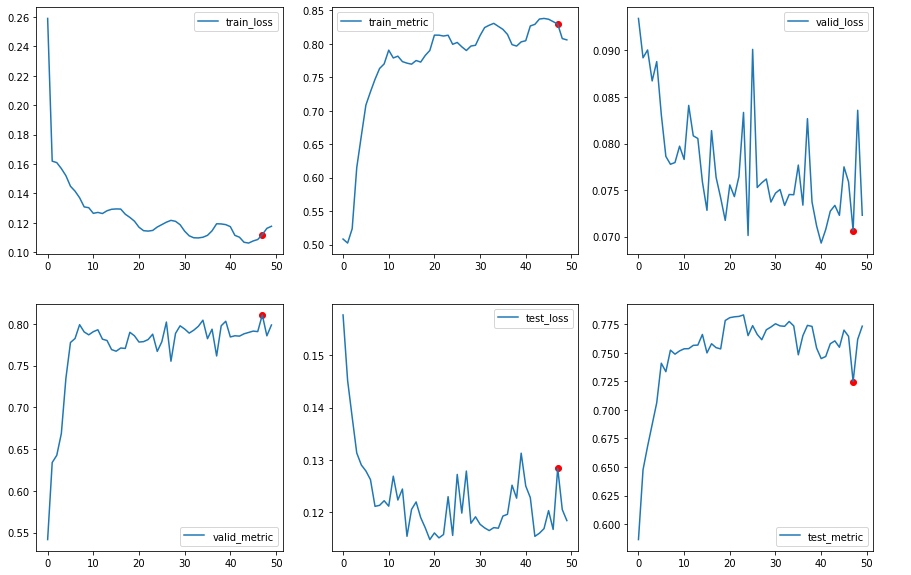

In [10]:
import matplotlib.pyplot as plt
labels = ['epoch', 'train_loss', 'train_metric', 'valid_loss', 'valid_metric', 'test_loss', 'test_metric']
fig = plt.figure(figsize=(15, 10))
stats_np = np.array(stats)
best_valid = stats_np[stats_np[:50, 4].argmax()]
print(best_valid)
for i in range(1, stats_np.shape[-1]):
    ax = fig.add_subplot(2, 3, i)
    ax.plot(stats_np[:, i], label=labels[i])
    ax.scatter(x=best_valid[0], y=best_valid[i], color='red')
    ax.annotate(best_valid[i].round(3), xy=(best_valid[0]+5, best_valid[i]), color='red')
    ax.legend()


In [11]:
from torch_geometric.utils import to_dense_adj, to_networkx, dense_to_sparse, remove_self_loops, to_undirected
from draw_mols_demo import pyg_to_mol, mol_to_svg, HorizontalDisplay

model.eval()
data = dataset[3]    
data.to(args.device)
strats = {'ea': data.edge_attr,  'rw': data.rw_edge_attr}
out = model(data.x, 0, data.edge_index, strats)

threshold = 0.975

# fig, axes = plt.subplots(nrows=len(model.gcs), ncols=2, figsize=(15, 10 * len(model.gcs)))
for layer_idx, gc in enumerate(model.gcs):
    imgs = []
    
    adj = to_dense_adj(edge_index=data.edge_index, edge_attr=gc.att)[0]
    adj_mean = adj.mean(dim=-1).detach().cpu()
    adj_max = adj.max(dim=-1)[0].detach().cpu()
    
    adj_mean_sorted = adj_mean.flatten().sort()[0]
    adj_mean_threshold = adj_mean_sorted[int(threshold * len(adj_mean_sorted))]
    adj_mean[adj_mean < adj_mean_threshold] = 0
    adj_mean[adj_mean >= adj_mean_threshold] = 1
    
#     adj_max_sorted = adj_max.flatten().sort()[0]
#     adj_max_threshold = adj_max_sorted[int(threshold * len(adj_max_sorted))]
#     adj_max[adj_max < max_threshold] = 0
#     adj_max[adj_max >= max_threshold] = 1
    
    mean_edge_index = dense_to_sparse(adj_mean.long())[0]
    mean_edge_index = remove_self_loops(mean_edge_index)[0]
    mean_data = Data(x=data.x, edge_index=mean_edge_index)
    
#     max_edge_index = dense_to_sparse(adj_max.long())[0]
#     max_edge_index = remove_self_loops(max_edge_index)[0]
#     max_data = Data(x=data.x, edge_index=max_edge_index)
    
    # ax = axes[layer_idx][0]
    # ax.set_title(f'Layer {layer_idx + 1}, Mean')
    # im = ax.matshow(adj_mean)
    # fig.colorbar(im, ax=ax)
    # molecule_draw_with_color(to_networkx(mean_data, node_attrs=['x']), ax=ax, labels='node_id')
    mol = pyg_to_mol(mean_data)  
    # mc = mol_to_svg(mol, molSize=(150, 150))
    svg = mol_to_svg(mol, molSize=(150, 150))
    imgs += [svg]
    
    # ax = axes[layer_idx][1]
    # ax.set_title(f'Layer {layer_idx + 1}, Max')
    # im = ax.matshow(adj_max)
    # fig.colorbar(im, ax=ax)
    # molecule_draw_with_color(to_networkx(max_data, node_attrs=['x']), ax=ax, labels='node_id')
    
    # mol = pyg_to_mol(max_data)  
    # mc = mol_to_svg(mol, molSize=(150, 150))
    svg = mol_to_svg(mol, molSize=(150, 150))
    # imgs += [svg]
    row = HorizontalDisplay(*imgs)
    display(row)

AttributeError: 'Data' object has no attribute 'rw_edge_attr'